# Natural Language Processing Fundamentals (Day 3)

**Goal:** Participants leave with "lexical" NLP skills to go from raw text data to insights to enable effective decision making.

_Lexical Analysis: the meaning of a word in isolation from the sentence containing it._ 

_Semantic Analysis: determining what a sentence or phrase really means based on contextual clues._  

**Day 1\-2 Objectives:**

1. ~~Understand common analytical tasks associated with NLP~~
2. ~~Understand how text extraction can be completed~~
3. ~~Understand and conduct common pre\-processing NLP tasks \(tokenization, spelling correction, stop word removal, stemming, lemmatization, casing, removal of digits / punctuation, etc.~~
4. ~~Understand and complete common lexical NLP analytical tasks~~

- <span style='font-size:small'>~~Part of Speech Tagging~~</span>
- <span style='font-size:small'>~~N\-gram formation~~</span>
- <span style='font-size:small'>~~Sentiment Analysis \(Bag of Words, lexicons \(Vader, Bing, NRC, AFINN, Loughran\)\)~~</span>
- <span style='font-size:small'>~~Basic \(very\) summarization of text~~</span>
- <span style='font-size:small'>~~Basic \(very\) translation~~</span>
- <span style='font-size:small'>~~Basic \(very\) classification~~</span>

**Day 3 Objectives:**

1. Finish understanding what "Bag of Words" is and what it can be used for
2. Introduce TF\-IDF and Word2Vec Embeddings
3. Understand what is meant by vector representations of words
4. Understand "similarity" measures \(Euclidian Distance, dot product, cosine similarity\)



# The task at hand...

Suppose for a moment, that the Math Department Head just received more than 1,500 student responses to a end of course survey. She is interested in what students perceive as HELPFUL and UNHELPFUL experiences. 

What kind of questions might she have?  



In [1]:
import nltk
import numpy
import string
import time
import re
import pandas as pd
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer #Valence Aware Dictionary for sEntiment Reasoning
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader as api

## **Load Course End Feedback**

The $\texttt{pd.read\_csv}$ command below captures preprocessing tasks completed during the last meetings: 

- Tokenization
- Proper Noun Deidentification
- Lower Casing 
- Removing Digits 
- Removing Punctuation
- Removing Whitespace
- Spell Checking 
- Optionally remove stopwords (create 2nd corpus)


In [2]:
helpfulNew = pd.read_csv('../data/helpfulNew.csv',keep_default_na=False)
helpfulNew.drop(columns=["Unnamed: 0"], inplace = True)
helpfulNew.head()
helpfulNew = helpfulNew['text']

### **Stopword Removal**

This is the process of removing the words that are so common that they don't provide any value to understanding the text. Examples shown below.  



In [3]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
new_stopwords = ["xxx"]
stop_words.extend(new_stopwords)

# create another dataframe without stopwords: helpfulNewStop
def removeStopWords(text,stop_words):
    text_tokens = word_tokenize(text)
    return ' '.join([w for w in text_tokens if not w in stop_words])

helpfulNewStop = helpfulNew.apply(lambda x: removeStopWords(str(x),stop_words))
# helpfulNewStop.head()
# print("Before Stop Words: ", helpfulNew[1], "\n\nAfter Stop Word Removal: ",helpfulNewStop[1])

## **So what do we mean when we say Bag of Words?**
_Adapted from [CS287: Deep Learning for NLP](https://harvard-iacs.github.io/CS287/schedule), a course offered in Fall 2021_

Extracting the occurrence of words within a document. It is a "bag" since we disregard the structure of a given sentence or how words interact with each other.  A model only cares about what words are used \- not the order in which they are used.   

Now, we analyze our corpus by creating *vector representations* of each document. These vector representations will allow us to work with documents as numerical data, compare them to one another, and hopefully design a useful information retrieval system.  

The first vector representation we will examine is **bag-of-words** (BoW). Here, in BoW, the dimension of each vector should represents the number of times a particular word occurs in a document.

**Word Mapping**

To start, we need to create a **vocabulary** that maps words to the indices of a vector. The `create_vocab()` function takes as input our `corpus` of strings and returns a dictionary that maps each unique word in the corpus to a unique integer *index*. The returned dictionary should satisfy the following properties:

- Each word is mapped to a number between $0$ and $V - 1$, inclusive, where $V$ is the number of unique words in the corpus.
- Words with higher frequency across the corpus should have smaller indices; i.e. the most frequent word should have index $0$ and the least frequent word should have index $V - 1$.  Ties are broken arbitrarily.



In [4]:
# use tokenized `corpus` and create an indexed vocabulary of every word in the corpus
# map words to indices of a vector to create a lookup table

from collections import Counter
from typing import Dict, List
from pandas import Series

def create_vocab(corpus: Series) -> Dict[str, int]:

    # concatenate all responses to get a list of every token used in the corpus
    all_words = corpus.str.cat(sep = ' ')
    token_list = nltk.word_tokenize(all_words)

    # use Counter to create dict of counts of all tokens
    token_dict = Counter(token_list)

    # make dict of {sorted **token_dict.most_common()** tokens : index}
    index_dict = dict([(x[0],y) for (x,y) in zip(token_dict.most_common(),range(len(token_dict)))])

    return index_dict


In [5]:
# sanity check cell
full_vocab = create_vocab(helpfulNew)
print("full vocab size:", len(full_vocab))
print("'the' index:", full_vocab['the'])
print("'board' index:", full_vocab['board'])
print("'problems' index:", full_vocab['problems'])
print("'are' index:", full_vocab['are'])
print("'fun' index:", full_vocab['fun'])

full vocab size: 796
'the' index: 0
'board' index: 19
'problems' index: 12
'are' index: 135
'fun' index: 209


### **BoW Representations**

Now, let's create the actual BoW representations. The function `create_bow()` does the following:
- accepts two inputs: `tokenized_corpus` and the output from `create_vocab()`
- it creates BoW representations for each comment and returns it
- specifically, the output needs to be a dictionary mapping each document id to a NumPy array $\vec x \in \mathbb{R}^V$, where $x_i$ is the number of times the word, whose index into the vocabulary is $i$, appears in the document. For example, if $i=0$ corresponds to "the", and "the" appears 17 times in the given document, then the 1st index of vector $\vec x$ should be 17.

In [6]:
tokenized_comments_helpful = helpfulNew.apply(lambda x: nltk.word_tokenize(str(x)))
tokenized_comments_helpful

0      [in, class, examples, were, great, for, xxx, x...
1      [i, particularly, thought, getting, up, to, th...
2      [every, time, we, would, go, to, boards, we, w...
3                      [humor, that, motivate, learning]
4      [during, almost, every, class, period, we, got...
                             ...                        
220    [when, the, xxx, was, in, the, classroom, we, ...
221    [the, note, sheets, for, grade, assignment, we...
222    [working, through, board, problems, helped, me...
223    [using, your, tablet, to, write, all, the, not...
224    [very, open, to, answering, difficult, questions]
Name: text, Length: 225, dtype: object

In [7]:
# create BoW representations based on counts of words in each comment
import numpy as np

def create_bow(tokenized_corpus: Series, vocab: Dict[str, int]) -> Dict[int, np.ndarray]:

    # empty dictionary to add {doc_id: bow_array} key,value pairs
    doc_map = {}

    # iterate through each comment by doc_id
    for doc_id, tokens in tokenized_corpus.to_dict().items():
        bow_array = np.zeros(len(vocab))#,dtype=int)
        token_count = Counter(tokens)

        # go through each word and match its count with the word's appropriate index
        #    based on the `vocab` dictionary
        for word,count in token_count.items():
            #print(doc_id)
            #if word != 'nan': # use this if your data contains nan
            idx = vocab[word]
            bow_array[idx] = count

        # add the resultant {doc_id: bow_array} key,value pair to the returned dictionary
        doc_map[doc_id] = bow_array

    return doc_map

In [8]:
# sanity check
full_bow = create_bow(tokenized_comments_helpful, full_vocab)
print("# keys:", len(full_bow.keys()))
print("vocab size:", len(full_bow[5]))
print(full_bow[5][:20])
print(full_bow[10][:20])

# keys: 225
vocab size: 796
[2. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [9]:
# use BoW with cosine similarity
def cos_sim(doc1,doc2,doc_dict):
    # get associated bow vectors of input docs
    a = doc_dict[doc1]
    b = doc_dict[doc2]

    return np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))

print(f'cosine similarity of comments 42 and 80: {cos_sim(42,80,full_bow)}')
print(f' * comment 42: {helpfulNew.loc[42]}')
print(f' * comment 80: {helpfulNew.loc[80]}')
print('\n')

print()

# pick two other course comments to examine
comment_1, comment_2 = 77, 188
print(f'cosine similarity of comments {comment_1} and {comment_2}: {cos_sim(comment_1,comment_2,full_bow)}')
print(f' * {comment_1}: {helpfulNew.loc[comment_1]}')
print(f' * {comment_2}: {helpfulNew.loc[comment_2]}')

cosine similarity of comments 42 and 80: 0.19069251784911848
 * comment 42: the instructor really helped us through the project
 * comment 80: taking boards is always the best way to learn i believe



cosine similarity of comments 77 and 188: 0.19399589841579265
 * 77: xxx xxx made us do a lot of board work every day to practice problems which helped me a lot she would then come by each students board and help correct them if needed
 * 188: doing real world problems associated with each lesson it really helped my understanding of how to actually apply the concepts we learned instead of just memorizing steps and functions


In [10]:
# Create a contrived string to show different cosine similarities
# similar to comment 80: 'taking boards is always the best way to learn i believe'
contrived_comment_a = 'i think taking boards is the best way to learn in class'
contrived_comment_b = 'assuming boards is most the greatest methods to understand problems i think'
contrived_tokenized_a = pd.Series(contrived_comment_a).apply(lambda x: nltk.word_tokenize(x))
contrived_tokenized_b = pd.Series(contrived_comment_b).apply(lambda x: nltk.word_tokenize(x))
contrived_bow_a = create_bow(contrived_tokenized_a, full_vocab)
contrived_bow_b = create_bow(contrived_tokenized_b, full_vocab)

# temporarily add contrived comment to `full_bow` dictionary
full_bow['contrived_a'] = contrived_bow_a[0]
full_bow['contrived_b'] = contrived_bow_b[0]

print(f' * comment 80: \t\t\t{helpfulNew.loc[80]}')
print(f' * contrived comment A: \t{contrived_comment_a}')
print(f' * contrived comment B: \t{contrived_comment_b}\n')

print(f'cosine similarity of comments 80 and contrived example A: {cos_sim(80,"contrived_a",full_bow)}')
print(f'cosine similarity of comments 80 and contrived example B: {cos_sim(80,"contrived_b",full_bow)}')

# # optionally remove contrived comment from `full_bow` dictionary
# del full_bow['contrived_a']
# del full_bow['contrived_b']

 * comment 80: 			taking boards is always the best way to learn i believe
 * contrived comment A: 	i think taking boards is the best way to learn in class
 * contrived comment B: 	assuming boards is most the greatest methods to understand problems i think

cosine similarity of comments 80 and contrived example A: 0.7833494518006403
cosine similarity of comments 80 and contrived example B: 0.4351941398892446


In [11]:
def doc_sim(doc1, doc_dict, k=5):

    cos_sim_dict = {}
    for doc2 in doc_dict.keys():
        if doc2 == doc1: 
            pass
        else:
            cos_sim_dict[doc2]=cos_sim(doc1,doc2,doc_dict)

    # I used the following stackoverflow page to sort by dict value
    #    https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value

    #  {doc_id: cos_sim to given doc}; sort by value REVERSE
    sorted_dict = {k: v for k, v in sorted(cos_sim_dict.items(), key=lambda item: item[1],reverse=True)}

    # resulting docids with closest cosine similarity
    sorted_docids = [x for x,y in zip(sorted_dict.keys(),range(k))]


    return sorted_docids 

# use function and print comments
comment_entry = 51
k=5
bowsim = doc_sim(comment_entry,full_bow,k)
print(f'Original comment: {helpfulNew.loc[comment_entry]}')
print(f'\n{k} most similar comments based on Bag of Words cosine similarity:')
for d in bowsim:
    print(f' *  {helpfulNew.loc[d]}')

Original comment: the path project i learned a lot about modeling and real world solutions

5 most similar comments based on Bag of Words cosine similarity:
 *  doing the path project
 *  the final path modeling day in this class used a lot of our skill in an advanced way but i still had a firm grasp on the material
 *  the experience of working in groups was one that i learned a lot from
 *  the xxx we worked with was helpful and very interesting and relevant to the material even though the projects we did took a long time i thought they supplemented the course well i also had not done path projects in the past it was strictly learning the material test and then the next topic
 *  i learned a lot since i was the only person who ever talked in class or asked any questions


In [12]:
def avg_doc_sim(bow_dict):
    '''
    Input:   BOW dictionary of doc_id: np.array of BOW vector
    Output:  a dictionary of doc_id:average cosine similarity across comments
    '''
    avg_doc_sim_dict = {}
    num_docs = len(bow_dict.keys())

    for doc1 in bow_dict.keys():
        # reset accumulator of document similarities
        docsim = 0
        for doc2 in bow_dict.keys():
            if doc2 == doc1:
                pass
            else:
                # accumulate total document similarity values
                docsim+=cos_sim(doc1,doc2,bow_dict)

        avg_doc_sim_dict[doc1] = docsim/(num_docs-1)

    return avg_doc_sim_dict

t0 = time.time()
avg_doc_sim_full = avg_doc_sim(full_bow)
print(f'total time = {time.time()-t0}')

total time = 0.20882821083068848


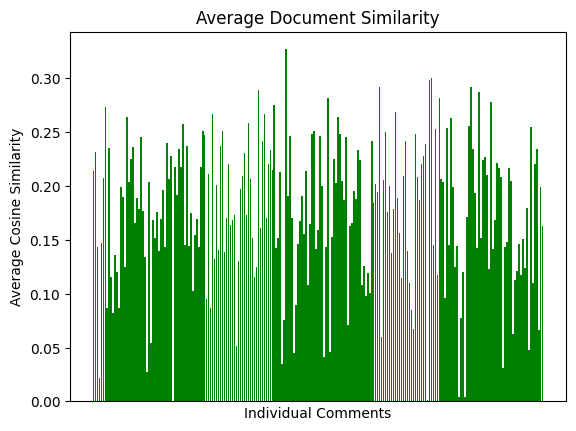

In [13]:
import matplotlib.pyplot as plt

x=range(len(full_bow))
x_labels = [x for x in avg_doc_sim_full.keys()]
y = [x for x in avg_doc_sim_full.values()]

plt.bar(x, y, color='green', align='center')
plt.title('Average Document Similarity')
plt.xticks([])
plt.ylabel('Average Cosine Similarity')
plt.xlabel('Individual Comments')
plt.show()

In [14]:
sort_y = sorted(y)

loc_min_y = list(avg_doc_sim_full.keys())[list(avg_doc_sim_full.values()).index(min(y))]
print(f'Comment with min cos sim:  {loc_min_y} with {min(y):.3f}')

loc_max_y = list(avg_doc_sim_full.keys())[list(avg_doc_sim_full.values()).index(max(y))]
print(f'Comment with max cos sim:  {loc_max_y} with {max(y):.3f}')

print(f'Average cos sim across all Comments:  {np.mean(y):.3f}')

print('\nmin cos_sim comment:')
print('  * '+helpfulNew.iloc[loc_min_y])
print('\nmax cos_sim comment:')
print('  * '+helpfulNew.iloc[loc_max_y])

print('\nLowest 10 cos_sim values:\tHighest 10 cos_sim values:')
for i,j in zip(sort_y[:10],sort_y[-10:]):
      print(f'{i:.3f}\t\t\t\t{j:.3f}')

Comment with min cos sim:  40 with 0.000
Comment with max cos sim:  97 with 0.326
Average cos sim across all Comments:  0.175

min cos_sim comment:
  * shoots

max cos_sim comment:
  * any time xxx xxx would go over our reading or run though the processes we studied the night before really helped to cement the concept and course material into my head i found that the most important source in the class was the teacher and the xxx in a real and xxx xxx text book

Lowest 10 cos_sim values:	Highest 10 cos_sim values:
0.000				0.277
0.002				0.282
0.004				0.282
0.004				0.287
0.022				0.289
0.027				0.291
0.031				0.292
0.035				0.298
0.042				0.300
0.045				0.326


Why do we have a comment that says "shoots"?

In [15]:
# Show that TextBlob's spell checker corrected "Kahoot" to shoots
test_string = 'kahoot'
print(f'{test_string} becomes {str(TextBlob(test_string).correct())}')

kahoot becomes shoot


### **Create TF-IDF vectors**


Instead of using BoW vectors with raw counts, let's try using term frequency-inverse document frequency (TF-IDF) vectors. Implement the `create_TFIDF()` function below. Its inputs and outputs are identical to `create_BoW()`:
- accept two inputs: the output from `load_corpus()` (e.g., `samp_tokenized` or `full_tokenized`) and the output from `create_vocab()` (e.g., `samp_vocab` or `full_vocab`)
- it creates TF-IDF representations for each comment and returns it. 
- specifically, the output needs to be a dictionary mapping each document id to a NumPy array $\vec x \in \mathbb{R}^V$, where $x_i$ is the TF-IDF for the word whose index into the vocabulary is $i$.

In [16]:
def create_TFIDF(tokenized_texts: Dict[int, List[str]], vocab: Dict[str, int]) -> Dict[int, np.ndarray]:
    
    # use create_bow to get all word counts for each doc_id
    bow_rep = create_bow(tokenized_texts,vocab)
    doc_count = len(bow_rep)
    
    # From TF-IDF Slide
    #    f_{w_i} = # times w_i appeared in document
    #    TFIDF = f_{w_i} * log(# docs in corpus / # docs containing w_i)
    
    # make matrix `f_w` of all BoW vectors to count # of docs with w_i
    f_w = []
    for vect in bow_rep.values():
        f_w.append(vect)
    
    f_w = np.array(f_w)
    
    # sum number of docs with each word by counting non-zero entries
    #    np.count_nonzero(array, axis=0) will count non-zero entries in each column ("across rows")
    word_by_doc = np.count_nonzero(f_w,axis=0)
    idfs = np.log(doc_count/word_by_doc)
    
    # create dictionary with {comment_index: TF-IDF representation} key/value pairs
    TFIDF_dict = {}
    for i,doc in enumerate(bow_rep.keys()):
        TFIDF_dict[doc] = f_w[i,:]*idfs

    return TFIDF_dict, idfs

In [17]:
# first, append two contrived comments to tokenized dataframe for follow-on demo purposes 
#   because TF-IDF requires the whole corpus!
tokenized_comments_helpful[len(tokenized_comments_helpful.index)] = contrived_tokenized_a[0]
tokenized_comments_helpful[len(tokenized_comments_helpful.index)] = contrived_tokenized_b[0]

# create TF-IDF
helpful_tfidf, idfs = create_TFIDF(tokenized_comments_helpful, full_vocab)

# look at comment 77 for insights
print(f'\n** Original Comment: {helpfulNew[77]}')
# examine first 12 entries of comment 77
print('\n** TF-IDF representation for first 12 entries of vector:')
print(helpful_tfidf[77][:12])

# print each unique word from comment 77 with its TF-IDF score

print('\n** TF-IDF score for each unique word in comment:')
duplicate_list = []
for word in tokenized_comments_helpful[77]:
    if word not in duplicate_list:
        duplicate_list.append(word)
        word_idx = full_vocab[word]
        print(f'{word}\t{helpful_tfidf[77][word_idx]}')
    else: continue


# for i,val in enumerate(helpful_tfidf[80][:12]):
#     print(f'{list(full_vocab.keys())[i]}\t{val}')




** Original Comment: xxx xxx made us do a lot of board work every day to practice problems which helped me a lot she would then come by each students board and help correct them if needed

** TF-IDF representation for first 12 entries of vector:
[0.         2.01221882 0.77098967 0.77098967 0.         0.
 2.4405148  0.         0.         1.28181529 0.         0.        ]

** TF-IDF score for each unique word in comment:
xxx	2.0122188193696093
made	3.6331905482533475
us	2.4805110383149622
do	2.7168998163791924
a	2.440514796180873
lot	5.1834733468503735
of	1.28181529108987
board	3.682862158050585
work	1.869601955991989
every	3.2277254401451834
day	3.6331905482533475
to	0.7709896673238792
practice	2.8600006600198657
problems	1.533129719370776
which	3.0270547446830323
helped	1.6407603835631415
me	1.7113779507770948
she	4.326337728813293
would	2.785892687866144
then	3.3455084758015667
come	4.7318028369214575
by	3.122364924487357
each	3.8155121050473024
students	3.4790398684260895
and	0.7709

Examine IDF scores for different words in vocabulary.

In [18]:
for i in range(12):
    print(f'{list(full_vocab.keys())[i]}\t{idfs[i]}')

print()

for i in range(188,200):
    print(f'{list(full_vocab.keys())[i]}\t{idfs[i]}')

the	0.43451743070266635
xxx	1.0061094096848047
to	0.7709896673238792
and	0.7709896673238792
in	0.8197798314933114
class	1.0682411907918108
a	1.2202573980904365
i	1.2660669341217308
was	1.235295275454977
of	1.28181529108987
we	1.4359659709171282
helpful	1.533129719370776

back	4.038655656361512
final	4.038655656361512
understood	4.038655656361512
solving	4.038655656361512
end	4.326337728813293
apply	4.038655656361512
teach	4.326337728813293
encouraged	4.326337728813293
instead	4.326337728813293
test	4.326337728813293
knowledge	4.326337728813293
showed	4.326337728813293


In [19]:
# see 5 nearest neighbors to a particular comment
comment_entry = 51
k=5
tfidf_sim = doc_sim(comment_entry,helpful_tfidf,k)
print(f'Original comment: {helpfulNew.loc[comment_entry]}')
print(f'\n{k} most similar comments based on TF-IDF cosine similarity:')
for d in tfidf_sim:
    print(f' *  {helpfulNew.loc[d]}')

Original comment: the path project i learned a lot about modeling and real world solutions

5 most similar comments based on TF-IDF cosine similarity:
 *  xxx work on path modeling days
 *  doing the path project
 *  trying to show real world application of path
 *  xxx project
 *  the experience of working in groups was one that i learned a lot from


In [20]:
# Create a contrived string to show different cosine similarities using TF-IDF
# similar to comment 84: 'taking boards is always the best way to learn i believe'
# contrived_comment_a = 'i think taking boards is the best way to learn in class'
# contrived_comment_b = 'assuming boards is most the greatest methods to understand problems i think'

print(f' * comment 80: \t\t\t{helpfulNew.loc[80]}')
print(f' * contrived comment A: \t{contrived_comment_a}')
print(f' * contrived comment B: \t{contrived_comment_b}\n')

# contrived_comment_a is at location 225; contrived_comment_b is at location 226
print(f'cosine similarity of comments 84 and contrived example A: {cos_sim(80,225,helpful_tfidf)}')
print(f'cosine similarity of comments 84 and contrived example B: {cos_sim(80,226,helpful_tfidf)}')

# optionally remove contrived comment from `full_bow` dictionary


 * comment 80: 			taking boards is always the best way to learn i believe
 * contrived comment A: 	i think taking boards is the best way to learn in class
 * contrived comment B: 	assuming boards is most the greatest methods to understand problems i think

cosine similarity of comments 84 and contrived example A: 0.7771950808000737
cosine similarity of comments 84 and contrived example B: 0.1458279504712885


### **Word2Vec Embeddings**



Google News has its own vectors and vocabulary. Below, we use these objects, along with your `tokenized_comments_helpful` to implement the following function `run_comment2vec()`, which assigns a vector to every comment based on the Word2Vec word vectors. If a word in the corpus happens to be missing from the Google News vocabulary, we skip it when computing document vectors [note: the denominator in the average is adjusted accordingly].

The function accepts as inputs:
- the output from `load_corpus()` (e.g., `samp_tokenized`)
- `gnews_vocab` (assigned in first cell at top of notebook)
- `gnews_vecs` (assigned in first cell at top of notebook)

It returns a dictionary, just like `create_TFIDF()`, whereby the keys are the doc ids and the values are the corresponding vectors.

### Load Word2Vec Model

In [21]:
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader as api
t0 = time.time()
gnews = api.load('word2vec-google-news-300')
gnews_vecs = gnews.vectors
gnews_vocab = gnews.key_to_index
total_time = time.time() - t0
print(f'Import load time: {total_time}')

Import load time: 26.33954381942749


### Find similar tokens (using pretrained model) to CHALKBOARD

In [22]:
gnews.most_similar("chalkboard")

[('blackboard', 0.8274536728858948),
 ('chalkboards', 0.6927468180656433),
 ('whiteboard', 0.6784566044807434),
 ('dry_erase', 0.6494746208190918),
 ('fingernails_scratching', 0.6353917121887207),
 ('macadamia_pursuant', 0.6210680603981018),
 ('blackboards', 0.5984241366386414),
 ('fingernails_scraping', 0.5554476380348206),
 ('Chalkboards', 0.5303213000297546),
 ('greaseboard', 0.5270883440971375)]

In [23]:
def run_comment2vec(tokenized_texts: Dict[int, List[str]], vocab: Dict[str, int], vecs: np.ndarray) -> Dict[int, np.ndarray]:
    doc_vecs = {}

    # using the word2vec word embeddings, take the mean of the word embeddings to form an
    # average embedding to represent the whole pdr comment
    for doc_id, doc in tokenized_texts.items():
        doc_vecs[doc_id] = np.mean([vecs[vocab[word]] for word in doc if word in vocab], axis=0)
    return doc_vecs

In [24]:
comment2vec = run_comment2vec(tokenized_comments_helpful, gnews_vocab, gnews_vecs)

# check the shape -- this is the mean of all of the word embeddings for a single PDR comment
# 300 is the vector length for these particular word2vec embeddings
print(comment2vec[80].shape)
# print(comment2vec[80])

(300,)


In [25]:
comment2vec_df = pd.DataFrame(comment2vec).T
comment2vec_norms = np.sqrt((comment2vec_df ** 2).sum(axis=1))
comment2vec_cosines = comment2vec_df @ comment2vec_df.T / comment2vec_norms.values / comment2vec_norms.values.reshape(-1, 1)
comment2vec_cosines

# Get top 5 recommendations for comment2vec
comment2vec_recs = comment2vec_cosines.apply(lambda x: pd.Series(x.nlargest(6).index[1:])).T

In [26]:
# Display closest comments given the average word2vec embedding
for comment_id in [60, 9, 14, 16]:
    print('**** Query ****')
    print(comment_id,'\t',helpfulNew.iloc[comment_id])
    
    print('\n**** comment2vec Recommendations ****')
    for rec_id in comment2vec_recs.loc[comment_id]:
        print(rec_id,'\t',helpfulNew.loc[rec_id])

    print('\n**** TF-IDF Recommendations ****')
    for rec_id in doc_sim(comment_id,helpful_tfidf,k):
        print(rec_id,'\t',helpfulNew.loc[rec_id])

    print('\n**** BoW Recommendations ****')
    for rec_id in doc_sim(comment_id,full_bow,k):
        print(rec_id,'\t',helpfulNew.loc[rec_id])


    print('\n')

**** Query ****
60 	 getting the chance to work with our classmates on the boards and then ask xxx xxx if we had any questions was helpful

**** comment2vec Recommendations ****
179 	 xxx xxx would always walk around and check our boards while we did board work if we weren understanding something he would carefully explain it to us until we did
77 	 xxx xxx made us do a lot of board work every day to practice problems which helped me a lot she would then come by each students board and help correct them if needed
97 	 any time xxx xxx would go over our reading or run though the processes we studied the night before really helped to cement the concept and course material into my head i found that the most important source in the class was the teacher and the xxx in a real and xxx xxx text book
1 	 i particularly thought getting up to the boards as soon as xxx xxx had a good feeling about our understanding of a concept was helpful i think xxx xxx did a pretty good job at balancing gettin

In [27]:
print('*** COMMENTS ***')
print(f' * comment 80: \t\t\t{helpfulNew.loc[80]}')
print(f' * contrived comment A: \t{contrived_comment_a}')
print(f' * contrived comment B: \t{contrived_comment_b}\n')

print('*** Bag of Words ***')
print(f'cosine similarity of comments 80 and contrived example A: {cos_sim(80,"contrived_a",full_bow)}')
print(f'cosine similarity of comments 80 and contrived example B: {cos_sim(80,"contrived_b",full_bow)}\n')

print('*** TF-IDF ***')
print(f'cosine similarity of comments 80 and contrived example A: {cos_sim(80,225,helpful_tfidf)}')
print(f'cosine similarity of comments 80 and contrived example B: {cos_sim(80,226,helpful_tfidf)}\n')

print('*** Word2Vec ***')
print(f'cosine similarity of comments 80 and contrived example A: {comment2vec_cosines[80][225]}')
print(f'cosine similarity of comments 80 and contrived example B: {comment2vec_cosines[80][226]}')

*** COMMENTS ***
 * comment 80: 			taking boards is always the best way to learn i believe
 * contrived comment A: 	i think taking boards is the best way to learn in class
 * contrived comment B: 	assuming boards is most the greatest methods to understand problems i think

*** Bag of Words ***
cosine similarity of comments 80 and contrived example A: 0.7833494518006403
cosine similarity of comments 80 and contrived example B: 0.4351941398892446

*** TF-IDF ***
cosine similarity of comments 80 and contrived example A: 0.7771950808000737
cosine similarity of comments 80 and contrived example B: 0.1458279504712885

*** Word2Vec ***
cosine similarity of comments 80 and contrived example A: 0.9489344954490662
cosine similarity of comments 80 and contrived example B: 0.8368156552314758


## **Preview of transformer-based transfer learning**

In [28]:
# uncomment these lines if you are operating on Google Colab or other cloud-based platform without a virtual environment.
# !pip install datasets
# !pip install transformers
# !pip install --upgrade torch torchvision

In [29]:
from transformers import pipeline, AutoConfig, AutoModel, AutoTokenizer
from datasets import Dataset
import torch 

c:\Users\john.scudder\Anaconda3\envs\aors\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
device = 0 if torch.cuda.is_available() else -1
print("Using: " "GPU" if device== 0 else "CPU" )

CPU


### Sentiment Analysis

In [31]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
classifier = pipeline("sentiment-analysis",model = MODEL, device = device) # device should make use of GPUs if set to 0... if -1 will default to CPUs

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
print("Comment: ", helpfulNew[0],"\n",classifier(helpfulNew[0]))
print("Comment: ", helpfulNew[1],"\n",classifier(helpfulNew[1]))
negCom = "This was the worst class I've ever had. The work was tedious and not related to my major."
print("Comment: ", negCom,"\n",classifier(negCom))

Comment:  in class examples were great for xxx xxx and xxx xxx to use for quires to see what material was essential to know for xxx 
 [{'label': 'positive', 'score': 0.9424242973327637}]
Comment:  i particularly thought getting up to the boards as soon as xxx xxx had a good feeling about our understanding of a concept was helpful i think xxx xxx did a pretty good job at balancing getting us to think to understand concepts and teach it to help us understand 
 [{'label': 'positive', 'score': 0.9298580884933472}]
Comment:  This was the worst class I've ever had. The work was tedious and not related to my major. 
 [{'label': 'negative', 'score': 0.9576689004898071}]


### Zero Shot Classification

In [33]:
classifier = pipeline("zero-shot-classification",model="facebook/bart-large-mnli")
classifier("This is a lesson about the incredible power of Transformers",candidate_labels=["education", "politics", "business"],)

{'sequence': 'This is a lesson about the incredible power of Transformers',
 'labels': ['education', 'business', 'politics'],
 'scores': [0.9968070983886719, 0.0021586946677416563, 0.0010341808665543795]}

### Text Generation

In [34]:
generator = pipeline("text-generation", model = 'gpt2')
generator("Once we leave this class about the benefits of healthy living, ", max_length=50, num_return_sequences=5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Once we leave this class about the benefits of healthy living, \xa0my favorite line of thinking is that no one would be surprised if we had a more stable existence after living in a more loving environment.\nBut what about the more common conclusion of'},
 {'generated_text': "Once we leave this class about the benefits of healthy living, \xa0that's when it really starts to make sense to consider what we can do to help those who have the greatest potential who don't.\nPosted by The author at 07:59"},
 {'generated_text': "Once we leave this class about the benefits of healthy living, \xa0we'll see how we can really make an interesting difference in that area!\nAnd if you would like to be on the receiving end of our ideas for making your own meals,"},
 {'generated_text': "Once we leave this class about the benefits of healthy living, \xa0we have now started to look further at our understanding of the benefits of eating well. Here's what happens when you're willing to 

### Mask Filling

In [35]:
unmasker = pipeline("fill-mask", model='bert-base-uncased')
unmasker("Natural Language [MASK] is a really cool analytical tool.", top_k=3)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'score': 0.5722203850746155,
  'token': 6364,
  'token_str': 'processing',
  'sequence': 'natural language processing is a really cool analytical tool.'},
 {'score': 0.08222448080778122,
  'token': 4106,
  'token_str': 'analysis',
  'sequence': 'natural language analysis is a really cool analytical tool.'},
 {'score': 0.038689740002155304,
  'token': 7654,
  'token_str': 'acquisition',
  'sequence': 'natural language acquisition is a really cool analytical tool.'}]

### Named Entity Recognition

In [36]:
ner = pipeline("ner", model = "dslim/bert-base-NER",grouped_entities=True)
ner("My name is Jack and I work at the US Military Academy in the Math Department.")

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
c:\Users\john.scudder\Anaconda3\envs\aors\Lib\site-packages\transformers\pipelines\token_classification.py:169: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy.SIMPLE"` instead.
  warnings.warn(


[{'entity_group': 'PER',
  'score': 0.99890816,
  'word': 'Jack',
  'start': 11,
  'end': 15},
 {'entity_group': 'ORG',
  'score': 0.9965072,
  'word': 'US Military Academy',
  'start': 34,
  'end': 53},
 {'entity_group': 'ORG',
  'score': 0.63952595,
  'word': 'Math Department',
  'start': 61,
  'end': 76}]

In [37]:
question_answerer = pipeline("question-answering", model = "distilbert-base-cased-distilled-squad")
question_answerer(
    question="Where am I employed?",
    context="My name is Jack and I work at the US Military Academy in the Math Department.",)

{'score': 0.47534841299057007,
 'start': 34,
 'end': 76,
 'answer': 'US Military Academy in the Math Department'}

### Summarization

In [38]:
summarizer = pipeline("summarization", model = "sshleifer/distilbart-cnn-12-6")
summarizer(
    """
Many years ago, as a student in a research methods course, I heard a most disappointing truth 8 that much of 
research is getting your data in order. Sigh. Certainly, the design, data collection, and 9 analysis phases 
are all key (and exciting) parts, but most research will include a requirement to convert 10 raw data into a 
more usable format. While many have accepted that this important, time consuming, 11 and unsatisfying part of 
research is just part of the process, this issue of The American Journal of Clinical 12 Nutrition features 
the work of the work of Hu, Ahmed, and L’Abbe [1] that demonstrates a viable way 13 to reduce this data 
wrangling burden. In their paper, the authors have applied state-of-the-art Natural 14 Language Processing 
(NLP) and Machine Learning (ML) techniques to accurately categorize food label 15 information. Demonstrating 
the impact of using these techniques, they use the University of Toronto 16 Food Label Information and Price 
(FLIP) database to identify a given label’s category (i.e. baked goods, 17 beverage, etc.) along with its 
nutritional quality. What is incredible about these results is the level of 18 accuracy that the authors 
achieve without the aid of a human reading and interpreting each label.
"""
)

[{'summary_text': ' The American Journal of Clinical Nutrition features the work of the authors of a new paper . They use state-of-the-art techniques to accurately categorize food labels . The authors say they can do this without the help of a human reading and interpreting the data . The study is published in the journal American Journal Of Clinical Nutrition, published in March 2013 .'}]

### Translation

In [39]:
#!pip install transformers[sentencepiece]
translator = pipeline("translation", model="Helsinki-NLP/opus-mt-es-en")
translator("Saludos compañeros procesadores de lenguaje natural! Espero que usted está teniendo una gran clase.")

c:\Users\john.scudder\Anaconda3\envs\aors\Lib\site-packages\transformers\models\marian\tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


[{'translation_text': 'Greetings fellow natural language processors! I hope you are having a great class.'}]